# Creating Mask Instances

This notebook converts a single binary image mask file into separate mask files for each object instance in the image.

In [1]:
from IPython.display import Image
import rasterio
import random
import skimage
import os
import pathlib
import math
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from rasterio.plot import show
from osgeo import gdal

## Image Masks

Pick a random chip from our directory of labeled chips to check the mask

In [64]:
# Labeled chip directory
labels_dir = 'img/labeled_tiffs'
# Get labeled image filenames
labeled = np.array(next(os.walk(labels_dir))[1])
# Add full paths
labeled = ['img/labeled_tiffs/' + s for s in labeled]

In [65]:
# Array of chips
chips = np.array(os.listdir(labeled[1]))

In [66]:
print(chips)

['20180410_020422_0f31_10_10' '20180410_020422_0f31_10_11'
 '20180410_020422_0f31_10_12' '20180410_020422_0f31_10_13'
 '20180410_020422_0f31_10_14' '20180410_020422_0f31_10_15'
 '20180410_020422_0f31_10_16' '20180410_020422_0f31_10_17'
 '20180410_020422_0f31_10_18' '20180410_020422_0f31_10_19'
 '20180410_020422_0f31_10_2' '20180410_020422_0f31_10_20'
 '20180410_020422_0f31_10_21' '20180410_020422_0f31_10_22'
 '20180410_020422_0f31_10_23' '20180410_020422_0f31_10_24'
 '20180410_020422_0f31_10_25' '20180410_020422_0f31_10_26'
 '20180410_020422_0f31_10_27' '20180410_020422_0f31_10_28'
 '20180410_020422_0f31_10_29' '20180410_020422_0f31_10_3'
 '20180410_020422_0f31_10_30' '20180410_020422_0f31_10_31'
 '20180410_020422_0f31_10_32' '20180410_020422_0f31_10_4'
 '20180410_020422_0f31_10_5' '20180410_020422_0f31_10_6'
 '20180410_020422_0f31_10_7' '20180410_020422_0f31_10_8'
 '20180410_020422_0f31_10_9' '20180410_020422_0f31_11_10'
 '20180410_020422_0f31_11_11' '20180410_020422_0f31_11_12'
 '201

No let's plot the mask for the chip

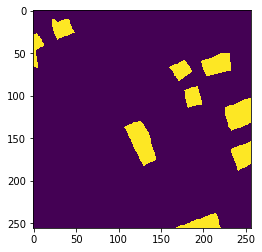

In [80]:
# Pick random chip to examine
chip_id = random.randint(1, 200)
chip = chips[chip_id]

# Directory of chip
chip_dir = labeled[1] + '/' + chip

# load the chip mask
mask_file = np.array(os.listdir(chip_dir + '/class_masks'))[0]
mask = rasterio.open(chip_dir + '/class_masks/' + mask_file)
show(mask)

## Connected Components

Next, we need to identify unique objects in the mask in order to create a new mask instance for each object. To accomplish this, we can first use connected components segmentation to label each patch.

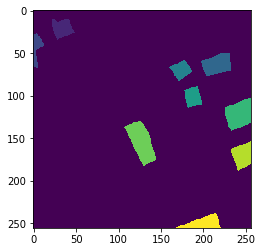

9


In [81]:
from scipy import ndimage
# Read in mask data
mask_array = mask.read()
# Label objects in mask and save labeled image as "labels" and number of objects as "nb"
labels, nb = ndimage.label(mask_array)
# Print labeled image and number of objects
show(labels)
print(nb)

Now that we've labeled the objects, let's loop over each object and create a new object-specific mask where all other object pixels are set to 0 (background).

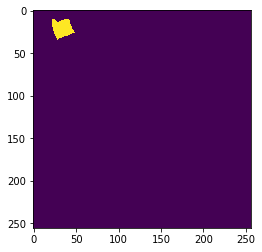

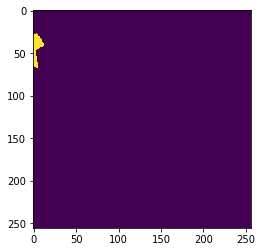

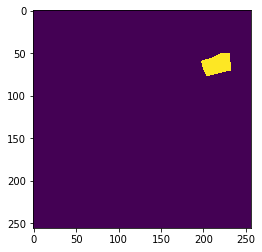

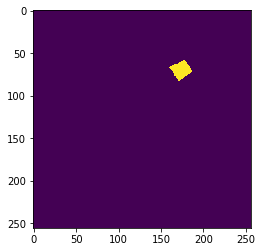

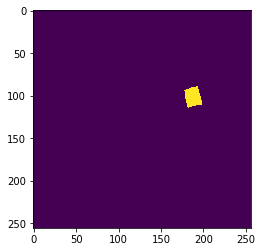

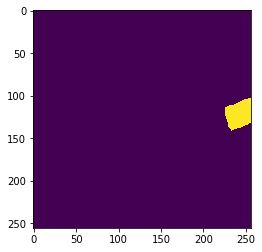

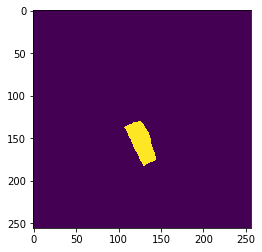

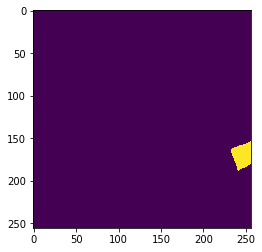

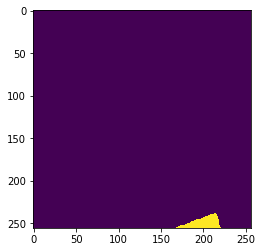

In [82]:
# Read in mask data
mask_array = mask.read()
# Label objects in mask and save labeled image as "labels" and number of objects as "nb"
labels, nb = ndimage.label(mask_array)

for obj in range(1,nb+1):
    # Make new object from labels
    m = labels * 1
    # Replace all other objects with 0s
    m[labels!=obj] = 0
    # Set object values to 1 (rather than object id number)
    m[labels==obj] = 1
    show(m)

Finally, we'll package the above code into a function that converts object instance masks for every labeled image chip in a directory.

In [108]:
# Labeled chip directory
labels_dir = 'img/labeled_tiffs'

# Get labeled image filenames
labeled = np.array(next(os.walk(labels_dir))[1])

# Get full paths
labeled = [labels_dir + '/' + s for s in labeled]

# Loop over labeled images
for l in labeled:

    # Array of chip directories
    chips = np.array(next(os.walk(l))[1])
    
    # Convert to directories
    chips = [l + '/' + c for c in chips]    

    # Loop over chips
    for c in chips:

        # Find number of masks
        masks = np.array(os.listdir(c + '/class_masks'))
        
        # Create directory to store instance masks
        instances = c + '/masks'
        pathlib.Path(instances).mkdir(parents=True, exist_ok=True)

        for mask in masks:

            # Get mask filename
            filename = mask.split('_mask.tif')[0]
            
            # Open mask
            mask = rasterio.open(c + '/class_masks/' + mask)

            # Read in mask data
            mask_array = mask.read(1)

            # Label objects in mask and save labeled image as "labels" and number of objects as "nb"
            labels, nb = ndimage.label(mask_array)

            for obj in range(1,nb+1):

                # Make new object from labels
                m = labels * 1
                # Replace all other objects with 0s
                m[labels!=obj] = 0
                # Set object values to 1 (rather than object id number)
                m[labels==obj] = 1                

                # Open a new GeoTiff data file in which to save the image chip
                with rasterio.open((c + '/masks/' + filename + '_label_' + str(obj) + '.tif'), 'w', driver='GTiff',
                           height=mask_array.shape[0], width=mask_array.shape[1], count=1,
                           dtype=rasterio.ubyte, crs=mask.crs, 
                           transform=mask.transform) as new_img:

                    # Write the rescaled image to the new GeoTiff
                    new_img.write(m.astype('uint8'),1)

/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
